In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm, trange
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)


In [4]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )

100%|██████████| 8557/8557 [00:02<00:00, 3696.77it/s]


timed_pocketsizes.shape=(8557, 10)


In [5]:
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]

# columns that need to be normalized (maybe?)
norm_cols = list(
    set(base_feat + opt_feat).intersection(
        ["mean_polydists", "defendersInBox", "yardsToGo"]
        + [f"poly_tau_{i}" for i in range(5, 41, 5)]
    )
)

print("build training and val set...")
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
    ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
)

X = pd.get_dummies(
    plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
    columns=["defensiveTeam", "possessionTeam"],
)
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
    ["defensiveTeam", "possessionTeam"]
]

X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

build training and val set...


In [26]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.lt(Y.pass_frame))
X["pass_event"] = Y.surv_frame.gt(Y.pass_frame)

for i in range(10, 36, 5):
    X[f"delta_{i}"] = X[f"poly_tau_{i}"] - X[f"poly_tau_{i-5}"]

X_train, X_test, Y_train, Y_test = train_test_split(X.index, Y.index, test_size=0.2)
Xs = X.iloc[X_train]
Xts = X.iloc[X_test]

In [27]:

data_df = pd.concat([Xs, Y.iloc[Y_train]], axis=1)
data_df["collapse_event"] = (~data_df["survived"]) & (
    data_df.surv_frame.lt(data_df.pass_frame)
)
data_df["pass_event"] = data_df.surv_frame.gt(data_df.pass_frame)
data_df["time"] = data_df[["surv_frame", "pass_frame"]].min(axis=1)

test_data_df = pd.concat([Xts, Y.iloc[Y_test]], axis=1)
test_data_df["collapse_event"] = (~test_data_df["survived"]) & (
    test_data_df.surv_frame.lt(test_data_df.pass_frame)
)
test_data_df["pass_event"] = test_data_df.surv_frame.gt(test_data_df.pass_frame)
test_data_df["time"] = test_data_df[["surv_frame", "pass_frame"]].min(axis=1)

stratas = ["shotgun", "pff_playAction"]
pass_concordances = []
collapse_concordances = []
verbose = 0
print("Condition baseline COX PH")
cond = [[], *[[coli] for coli in opt_feat]] + [
    [
        "poly_tau_10",
        "poly_tau_20",
        "poly_tau_30",
    ],
    [
        "poly_tau_20",
        "poly_tau_25",
        "poly_tau_30",
    ],
]

Condition baseline COX PH


In [28]:
add_feat = ["poly_tau_20","poly_tau_25",]

In [29]:
pass_cox = CoxPHFitter(strata=stratas)
pass_cox.fit(
    data_df[base_feat + add_feat + ["pass_event", "time"]],
    duration_col="time",
    event_col="pass_event",
    robust=True,
)
pass_cox.score(test_data_df, "concordance_index")

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


np.float64(0.5776756143383832)

In [30]:
collapse_cox = CoxPHFitter(strata=stratas)
collapse_cox.fit(
    data_df[base_feat + add_feat + ["collapse_event", "time"]],
    duration_col="time",
    event_col="collapse_event",
    robust=True,
)
collapse_cox.score(test_data_df, "concordance_index")

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


np.float64(0.8956128245610256)

In [31]:
test_data_df

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,pass_event,delta_10,delta_15,delta_20,delta_25,delta_30,delta_35,survived,surv_frame,pass_frame
962,-0.2214,-0.0240,False,False,True,False,False,False,False,1,...,False,1.3084,2.0386,0.8668,-0.4526,-1.6815,-0.8934,False,33,35
2251,-1.2668,-0.0240,False,False,False,False,True,False,False,0,...,False,0.6159,0.1351,-0.6504,-0.3190,-0.8931,0.0757,False,30,42
3002,0.3013,-1.1043,False,False,False,False,False,True,False,0,...,False,0.5975,0.1043,-0.5719,-1.0806,-0.1642,0.0757,False,26,30
6249,0.3013,-1.1043,False,False,False,False,False,False,False,0,...,False,-0.4314,0.2115,0.6021,0.2125,0.0588,-0.3492,False,40,63
1219,-0.2214,-0.0240,False,False,True,False,False,False,False,0,...,False,-1.1154,-2.1377,1.5051,0.4401,0.8260,-0.5829,False,13,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,-0.7441,-2.1847,False,False,True,False,False,False,False,0,...,True,-0.1797,0.4850,0.3986,-0.5744,0.1866,0.2424,True,26,21
955,-0.2214,2.1368,False,False,True,False,False,False,False,1,...,False,0.3847,-0.8583,0.8231,0.4401,0.1673,0.0757,False,17,22
6929,0.0399,2.1368,False,False,False,False,False,False,False,0,...,True,0.0684,0.2973,0.6069,-0.0842,0.1640,0.3922,True,29,24
5141,3.4375,-2.1847,False,False,True,False,False,False,False,0,...,False,0.0061,-0.5650,-1.9742,0.4401,0.1673,0.1877,False,20,70


In [32]:
tau = 30
times = np.arange(tau+1)

cum_hazard_collapse = collapse_cox.predict_cumulative_hazard(test_data_df[base_feat + add_feat + ["collapse_event", "time"]], times=times).T 
diff_hazard_collapse = cum_hazard_collapse.diff(axis=1).fillna(0.0)

cum_hazard_pass = pass_cox.predict_cumulative_hazard(test_data_df[base_feat + add_feat + ["pass_event", "time"]], times=times).T 
diff_hazard_pass = cum_hazard_pass.diff(axis=1).fillna(0.0)

cum_hazard_agg = cum_hazard_pass+cum_hazard_collapse
diff_hazard_agg = cum_hazard_agg.diff(axis=1).fillna(0.0)
agg_survival = np.exp(-cum_hazard_agg).shift(axis=1, periods=1, fill_value=1.0)

cif_c = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_collapse/diff_hazard_agg).sum(axis=1)
cif_p = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_pass/diff_hazard_agg).sum(axis=1)
surv = 1-cif_c-cif_p
preds = pd.concat([
        cif_c, 
        cif_p,
        surv,
        Y["surv_frame"].le(tau) & Y["surv_frame"].lt(Y["pass_frame"]),
        Y["pass_frame"].le(tau) & Y["pass_frame"].le(Y["surv_frame"]),
        Y["surv_frame"].gt(tau) & Y["pass_frame"].gt(tau)],
    axis=1).rename(columns={0:"cif_c", 1:"cif_p", 2:"surv", 3:"collapse", 4:"pass", 5:"survived"}).dropna(axis=0)

In [33]:
def plot_calibration_plot(preds_df, bs:int=1, i_c="cif_c", i_p="cif_p", surv=None):
    if surv:
        fig, ax = plt.subplots(2,3, figsize=(16,9), height_ratios=(2,1), sharex=True)
    else:
        fig, ax = plt.subplots(2,2, figsize=(12,9), height_ratios=(2,1), sharex=True)
    
    ax[0,0].plot([0,100], [0,1], alpha=.3, linestyle=":")
    ax[0,1].plot([0,100], [0,1], alpha=.3, linestyle=":")

    cgrps = preds_df[["collapse"]].groupby((preds_df[i_c]*100)//bs).mean().reset_index()
    ax[0,0].scatter(cgrps[i_c]*bs, cgrps["collapse"])

    ((preds_df[i_c]*100)).plot.hist(bins=25, ax=ax[1,0])

    pgrps = preds_df[["pass"]].groupby((preds_df[i_p]*100)//bs).mean().reset_index()
    ax[0,1].scatter(pgrps[i_p]*bs, pgrps["pass"])

    ((preds_df[i_p]*100)).plot.hist(bins=25, ax=ax[1,1])

    ax[0,0].set_title("Binned CIF_c vs observed collapse rate")
    ax[0,1].set_title("Binned CIF_p vs observed collapse rate")

    ax[0,0].set_xlabel("Estimated CIF_c @ 2.0- 2.5 s")
    ax[0,1].set_xlabel("Estimated CIF_p @ 2.0- 2.5 s")

    ax[0,0].set_ylabel("Observed collapse rate @ 2.0- 2.5 s")
    ax[0,1].set_ylabel("Observed pass rate @ 2.0- 2.5 s")

    ax[1,0].set_xlabel("Estimated CIF_c @ 2.0- 2.5 s")
    ax[1,1].set_xlabel("Estimated CIF_p @ 2.0- 2.5 s")

    ax[1,0].set_title("Frequency of estimated CIF_c")
    ax[1,1].set_title("Frequency of estimated CIF_p")
    ax[0,0].vlines(preds_df[i_c].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
    ax[0,1].vlines(preds_df[i_p].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
    ax[1,0].vlines(preds_df[i_c].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
    ax[1,1].vlines(preds_df[i_p].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
    
    if surv: 
        sgrps = (~preds_df["collapse"] & ~preds_df["pass"]).groupby((preds_df[surv]*100)//bs).mean().reset_index()
        ax[0,2].scatter( sgrps[surv]*bs, sgrps[0])

        ((preds_df[surv]*100)).plot.hist(bins=25, ax=ax[1,2])
        ax[0,2].plot([0,100], [0,1], alpha=.3, linestyle=":")   
        ax[0,2].set_title("Binned 1-CIF vs observed survival rate")
        ax[0,2].set_xlabel("Estimated 1-CIF @ 2.0- 2.5 s")
        ax[0,2].set_ylabel("Observed survival @ 2.0- 2.5 s")
        ax[1,2].set_xlabel("Estimated survival @ 2.0- 2.5 s")
        ax[1,2].set_title("Frequency of estimated survival")
        ax[0,2].vlines(preds_df[surv].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 1, alpha=.3)
        ax[1,2].vlines(preds_df[surv].quantile([0.05, 0.95]).values*100, ymin = 0, ymax = 500, alpha=.3)
    fig.tight_layout()
    plt.show()

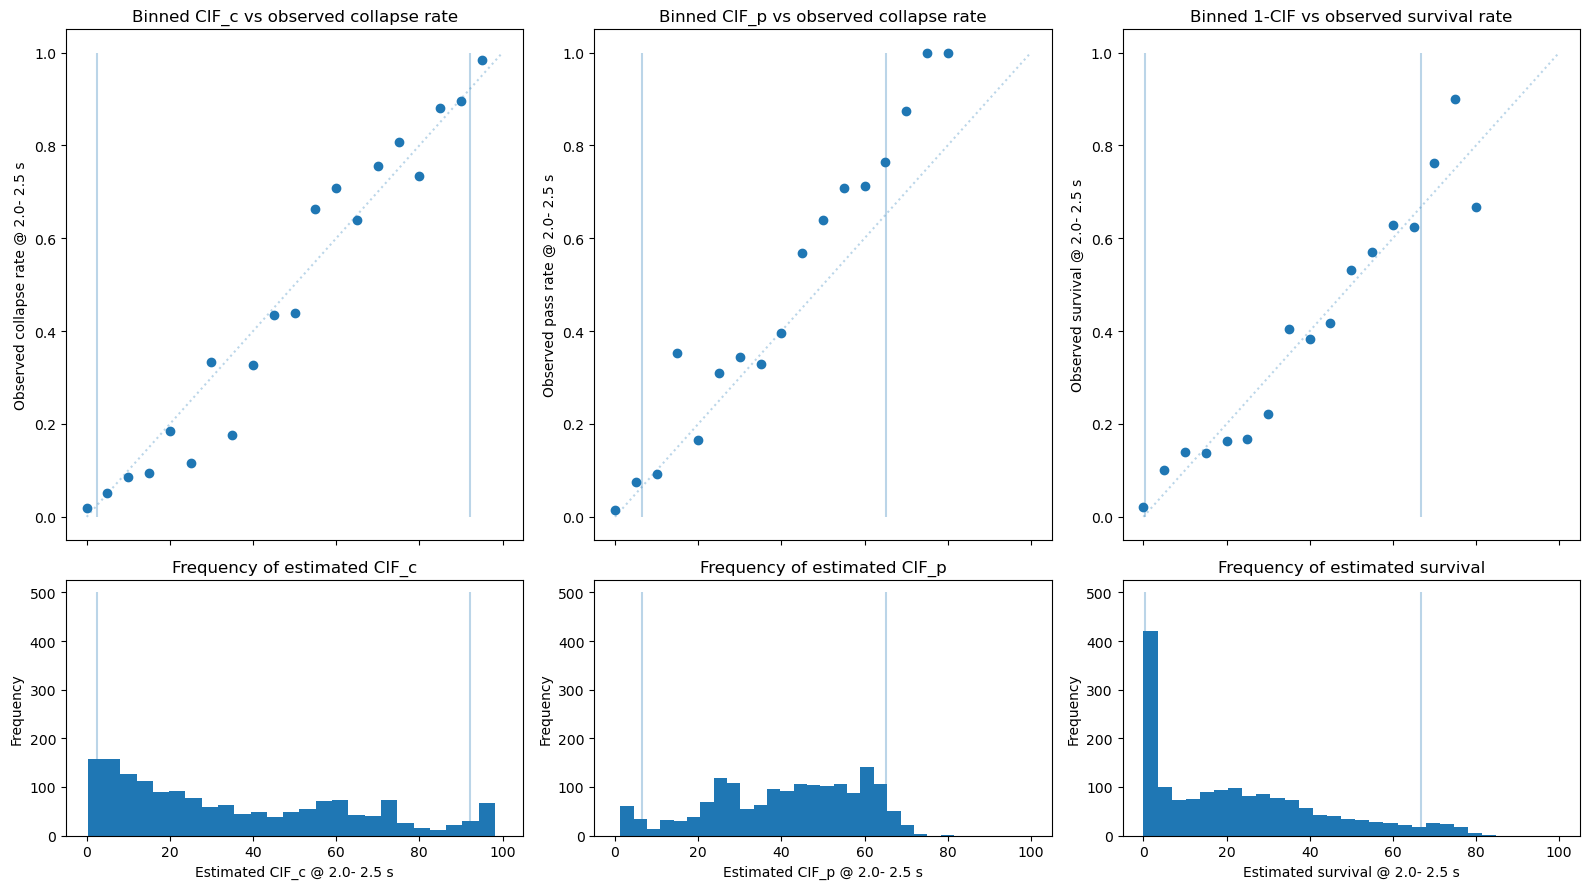

In [34]:
plot_calibration_plot(preds, bs=5, surv="surv")

# including the pocket size at landmarks: 
# first try: size at $T_L$, $\Delta$ size at $[T_L-5, T_L]$ for different $T_L \in {1.0, 1.5, 2.0, 2.5, 3.0}$ and then $CIF_{c/p}(t>T_L | S(T_L) = 1)$

In [137]:
def fit_and_predict_landmark(
        data_df:pd.DataFrame, 
        test_data_df:pd.DataFrame, 
        Y:pd.DataFrame, 
        tau_landmark:int = 15, 
        tau:int = 30, 
        base_feat:list[str] = base_feat,
    ) -> pd.DataFrame: 
    # use pocket size @ landmark (+ delta before) to predict cause specific hazards 
    # then check for rest of possession (i.e. at different taus)
    # 0. prepare data 
    add_feat = [f"poly_tau_{tau_landmark}", f"delta_{tau_landmark}",]
    data_df = data_df[data_df.time.gt(tau_landmark)]
    test_data_df = test_data_df[test_data_df.time.gt(tau_landmark)]
    
    # 1. fit models
    collapse_cox = CoxPHFitter(strata=stratas)
    collapse_cox.fit(
        data_df[base_feat + add_feat + ["collapse_event", "time"]],
        duration_col="time",
        event_col="collapse_event",
        robust=True,
    )
    pass_cox = CoxPHFitter(strata=stratas)
    pass_cox.fit(
        data_df[base_feat + add_feat + ["pass_event", "time"]],
        duration_col="time",
        event_col="pass_event",
        robust=True,
    ) 
    print(collapse_cox.score(test_data_df, "concordance_index"))
    print(pass_cox.score(test_data_df, "concordance_index"))

    
    # predict cause specific hazards
    rel_tau = tau-tau_landmark
    times = np.arange(rel_tau+1)
    cond_times = np.zeros(len(test_data_df))+tau_landmark
    
    cum_hazard_collapse = collapse_cox.predict_cumulative_hazard(
        data_df[base_feat + add_feat + ["collapse_event", "time"]], 
        times=times,
        conditional_after=cond_times).T 
    diff_hazard_collapse = cum_hazard_collapse.diff(axis=1).fillna(0.0)

    cum_hazard_pass = pass_cox.predict_cumulative_hazard(
        data_df[base_feat + add_feat + ["pass_event", "time"]], 
        times=times,
        conditional_after=cond_times).T 
    diff_hazard_pass = cum_hazard_pass.diff(axis=1).fillna(0.0)

    # compute cif
    cum_hazard_agg = cum_hazard_pass+cum_hazard_collapse
    diff_hazard_agg = cum_hazard_agg.diff(axis=1).fillna(0.0)
    agg_survival = np.exp(-cum_hazard_agg).shift(axis=1, periods=1, fill_value=1.0)
    
    print("------ surv: ")
    print(agg_survival.head())
    print("------ H_agg")
    print(cum_hazard_agg.head())
    print("------ H_collapse")
    print(cum_hazard_collapse.head())
    print("------ H_pass")
    print(cum_hazard_pass.head())
    print("------ h_agg")
    print(diff_hazard_agg.head())
    print("------ h_collapse")
    print(diff_hazard_collapse.head())
    print("------h_pass")
    print(diff_hazard_pass.head())
    print("====="*16)
    cif_c = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_collapse/diff_hazard_agg).sum(axis=1)
    cif_p = (agg_survival * (1-np.exp(-diff_hazard_agg))*diff_hazard_pass/diff_hazard_agg).sum(axis=1)
    surv2 = 1-cif_c-cif_p
    surv = agg_survival[rel_tau]
    print(surv)
    print(surv2)
    
    preds = pd.concat([
        cif_c, 
        cif_p,
        surv2,
        data_df["surv_frame"].le(tau) & data_df["surv_frame"].lt(data_df["pass_frame"]),
        data_df["pass_frame"].le(tau) & data_df["pass_frame"].le(data_df["surv_frame"]),
        data_df["surv_frame"].gt(tau) & data_df["pass_frame"].gt(tau)
        ],
    axis=1).rename(columns={0:"cif_c", 1:"cif_p", 2:"surv", 3:"collapse", 4:"pass", 5:"survived"}).dropna(axis=0)
    return preds

In [140]:
preds = fit_and_predict_landmark(
    data_df=data_df,
    test_data_df=data_df,
    Y=Y,
)

0.7253586907830881
0.5812559869593203
------ surv: 
      0.0   1.0   2.0     3.0     4.0     5.0     6.0     7.0     8.0   \
5296   1.0   1.0   1.0  0.9230  0.8278  0.7174  0.6034  0.5014  0.4239   
2142   1.0   1.0   1.0  0.9731  0.9323  0.8877  0.8342  0.7879  0.7447   
4608   1.0   1.0   1.0  0.9658  0.9160  0.8606  0.7958  0.7388  0.6874   
7514   1.0   1.0   1.0  0.9577  0.8976  0.8306  0.7540  0.6866  0.6277   
7578   1.0   1.0   1.0  0.9569  0.8930  0.8250  0.7463  0.6804  0.6211   

        9.0     10.0    11.0    12.0    13.0    14.0    15.0  
5296  0.3488  0.2931  0.2334  0.1945  0.1441  0.1088  0.0835  
2142  0.6958  0.6521  0.6004  0.5575  0.5003  0.4581  0.4163  
4608  0.6307  0.5815  0.5242  0.4785  0.4176  0.3725  0.3303  
7514  0.5641  0.5105  0.4491  0.4019  0.3397  0.2942  0.2536  
7578  0.5566  0.5012  0.4387  0.3893  0.3269  0.2834  0.2429  
------ H_agg
      0.0   1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0   \
5296   0.0   0.0  0.0801  0.1890  0.

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


<Axes: >

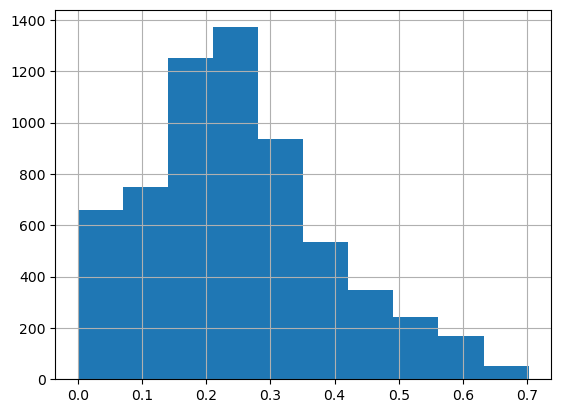

In [141]:
preds.surv.hist()

In [142]:
np.exp(-0.9685) 

np.float64(0.37965208934228595)

In [143]:
preds

,cif_c,cif_p,surv,collapse,pass,survived
5296,0.5944,0.3454,0.0601,True,False,False
2142,0.1573,0.4649,0.3778,False,True,False
4608,0.2382,0.4712,0.2906,False,True,False
7514,0.2976,0.4867,0.2157,False,True,False
7578,0.2065,0.5860,0.2075,False,True,False
...,...,...,...,...,...,...
7127,0.3371,0.2239,0.4391,False,True,False
4952,0.3408,0.2873,0.3719,False,True,False
7531,0.7766,0.1975,0.0259,True,False,False
8110,0.3479,0.2493,0.4027,True,False,False


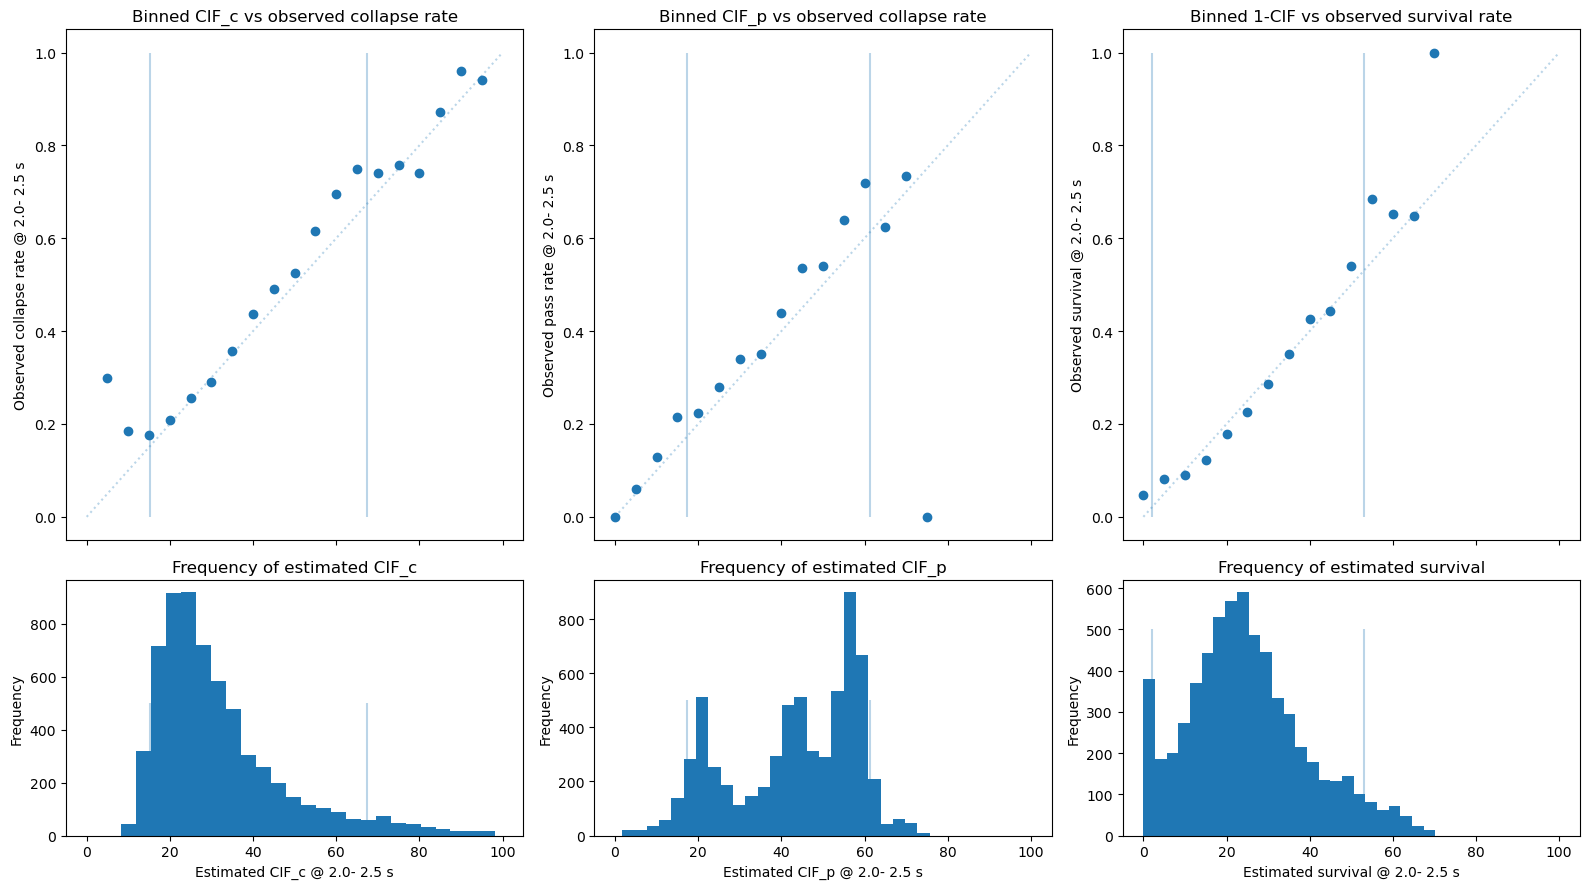

In [144]:
plot_calibration_plot(preds, bs=5, surv="surv")


In [134]:
preds.head(25)

,cif_c,cif_p,surv,collapse,pass,survived
2345,0.1795,0.4409,0.3797,True,False,False
1029,0.1862,0.4767,0.3372,False,True,False
991,0.2539,0.4629,0.2833,False,True,False
6188,0.1299,0.5580,0.3122,False,False,True
3840,0.1700,0.5648,0.2652,False,True,False
2579,0.2085,0.4003,0.3912,True,False,False
1086,0.4950,0.4130,0.0920,False,True,False
7742,0.2242,0.6295,0.1462,False,True,False
3322,0.2970,0.4722,0.2308,False,True,False
363,0.1271,0.6865,0.1864,False,True,False


In [145]:
from sklearn.metrics import brier_score_loss

In [160]:
print(f"brier score collapses: {brier_score_loss(preds.collapse, preds.cif_c):.4f}")
print(f"brier score passes: {brier_score_loss(preds["pass"], preds.cif_p):.4f}")
print(f"brier score collapses: {brier_score_loss(preds["survived"], preds["surv"]):.4f}")

brier score collapses: 0.1895
brier score passes: 0.2201
brier score collapses: 0.1522
